In [4]:
import itertools
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.ticker import MaxNLocator

In [5]:
path = "/home/tycho/CLS/2024-2025/Individual_Project/FabSim3/plugins/FabFlee/config_files/dflee_myanmar/"

In [6]:
locations = pd.read_csv("Myanmar- Locations.csv")
locations.drop(columns=["description"], inplace=True)
locations.head()

,WKT,name
0,POINT (96.4302635 18.9436415),Town_1
1,POINT (96.4520608 18.9490161),Flood_Zone_1
2,POINT (96.4488261 18.9592898),Flood_Zone_2
3,POINT (96.4420314 18.9844455),Flood_Zone_3
4,POINT (96.4533819 18.9829274),Town_2


In [ ]:
def extract_coords(point_str):
    coords = re.findall(r"[-+]?\d*\.\d+|\d+", point_str)
    return float(coords[0]), float(coords[1])


locations[["longitude", "latitude"]] = locations["WKT"].apply(
    lambda x: pd.Series(extract_coords(x))
)
locations.drop(columns=["WKT"], inplace=True)
locations.head()

,name,longitude,latitude
0,Town_1,96.430263,18.943641
1,Flood_Zone_1,96.452061,18.949016
2,Flood_Zone_2,96.448826,18.959290
3,Flood_Zone_3,96.442031,18.984445
4,Town_2,96.453382,18.982927


In [8]:
# name,region,country,latitude,longitude,location_type,conflict_period,population
df_locations = pd.DataFrame(
    columns=[
        "#name",
        "region",
        "country",
        "latitude",
        "longitude",
        "location_type",
        "conflict_period",
        "population",
    ]
)
df_locations["#name"] = locations["name"]
df_locations["region"] = "Toungoo"
df_locations["country"] = "Myanmar"
df_locations["latitude"] = locations["latitude"]
df_locations["longitude"] = locations["longitude"]

df_locations["location_type"] = (
    df_locations["#name"].str.lower().str.replace(r"_\d+$", "", regex=True)
)
df_locations.sort_values(by="#name", inplace=True)
# df_locations.to_csv(path + "input_csv/locations.csv", index=False)

In [9]:
pairs = list(itertools.combinations(locations["name"], 2))

df_routes = pd.DataFrame(pairs, columns=["from", "to"])
df_routes["distance (km)"] = 0

# df_routes.to_csv(path + "input_csv/routes.csv", index=False)

In [10]:
# df = pd.read_csv(
#     path + "routes.csv", header=None, names=["from", "to", "distance (km)"]
# )
# df.sort_values(by=["from", "to"], inplace=True)
# df.to_csv(path + "routes.csv", index=False, header=False)

In [11]:
toungoo_df = pd.read_csv("data/Toungoo_waterlevel.csv", sep=",")
toungoo_df.head()

danger_level = toungoo_df["Danger level (CM)"][0]
toungoo_df["Date"] = pd.to_datetime(toungoo_df["Date"])
toungoo_df["Day"] = toungoo_df["Date"].dt.strftime("%d")

In [12]:
x = 5  # Replace with your desired maximum classification value

min_level = toungoo_df["Water level at (12:30) hr (cm)"].min()
max_level = toungoo_df["Water level at (12:30) hr (cm)"].max()


def classify_water_level(level, min_level, max_level, x):
    if level < min_level:
        return 0
    else:
        return round((level - min_level) / (max_level - min_level) * x)


toungoo_df["Water Level Classification"] = toungoo_df[
    "Water level at (12:30) hr (cm)"
].apply(classify_water_level, args=(danger_level, max_level, x))

print(f"Min: {min_level}, Max: {max_level}")
print(toungoo_df[["Water level at (12:30) hr (cm)", "Water Level Classification"]])

Min: 527, Max: 805
    Water level at (12:30) hr (cm)  Water Level Classification
0                              564                           0
1                              549                           0
2                              552                           0
3                              593                           0
4                              656                           1
5                              735                           3
6                              805                           5
7                              774                           4
8                              744                           4
9                              726                           3
10                             716                           3
11                             710                           3
12                             700                           2
13                             698                           2
14                             692  

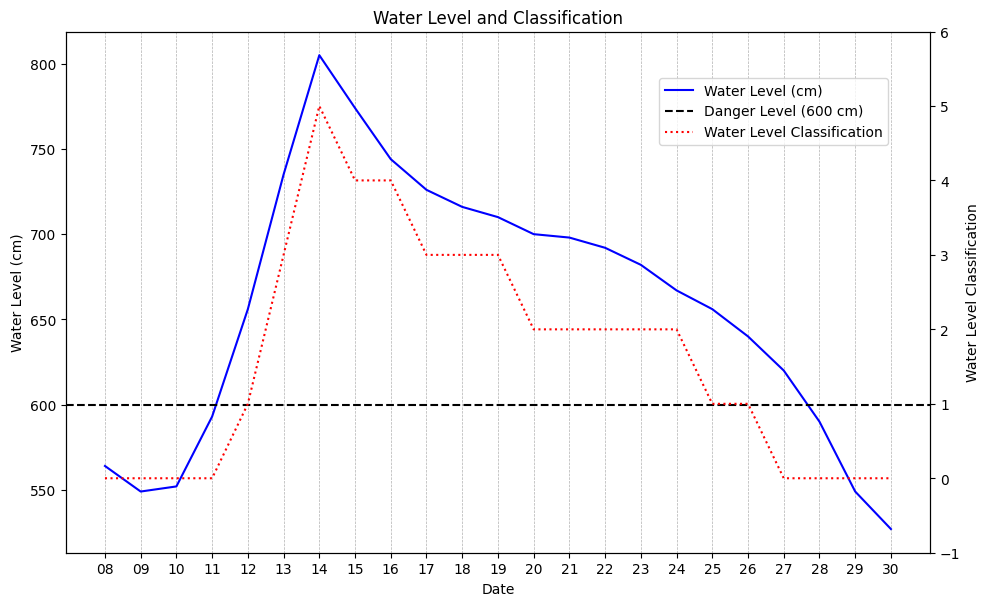

In [13]:
fig, ax1 = plt.subplots(figsize=(10, 6))

# Water Level
ax1.plot(
    toungoo_df["Day"],
    toungoo_df["Water level at (12:30) hr (cm)"],
    label="Water Level (cm)",
    color="b",
)
ax1.set_xlabel("Date")
ax1.set_ylabel("Water Level (cm)")
ax1.tick_params(axis="y")
ax1.grid(True, which="both", axis="x", linestyle="--", linewidth=0.5)


# Danger Level
plt.axhline(
    y=danger_level,
    color="black",
    linestyle="--",
    label=f"Danger Level ({danger_level} cm)",
)

# Classification
ax2 = ax1.twinx()
ax2.plot(
    toungoo_df["Day"],
    toungoo_df["Water Level Classification"],
    label="Water Level Classification",
    linestyle=":",
    color="r",
)
ax2.set_ylabel("Water Level Classification")
ax2.tick_params(axis="y")
ax2.set_ylim(-1, x + 1)
ax2.yaxis.set_major_locator(MaxNLocator(integer=True))


fig.tight_layout()
plt.title("Water Level and Classification")
fig.legend(loc="upper right", bbox_to_anchor=(0.9, 0.9))
plt.show()

In [14]:
locations_list = locations["name"].to_numpy()
locations_list.sort()
locations_list

array(['Camp_1', 'Camp_2', 'Camp_3', 'Camp_4', 'Flood_Zone_1',
       'Flood_Zone_10', 'Flood_Zone_11', 'Flood_Zone_12', 'Flood_Zone_13',
       'Flood_Zone_14', 'Flood_Zone_15', 'Flood_Zone_16', 'Flood_Zone_2',
       'Flood_Zone_3', 'Flood_Zone_4', 'Flood_Zone_5', 'Flood_Zone_6',
       'Flood_Zone_7', 'Flood_Zone_8', 'Flood_Zone_9', 'Town_1',
       'Town_10', 'Town_11', 'Town_2', 'Town_3', 'Town_4', 'Town_5',
       'Town_6', 'Town_7', 'Town_8', 'Town_9'], dtype=object)

In [15]:
columns = np.concatenate([["#Day"], locations_list])
df_flood_level = pd.DataFrame(columns=columns)

df_flood_level["#Day"] = toungoo_df.index
for col in df_flood_level.columns:
    if "flood_zone" in col.lower():
        df_flood_level[col] = toungoo_df["Water Level Classification"]
    elif "town" in col.lower():
        df_flood_level[col] = toungoo_df["Water Level Classification"].apply(
            lambda x: max(x - 3, 0)
        )
    elif "camp" in col.lower():
        df_flood_level[col] = 0

# df_flood_level.to_csv(path + "input_csv/flood_level.csv", index=False)
df_flood_level.head()

,#Day,Camp_1,Camp_2,Camp_3,Camp_4,Flood_Zone_1,Flood_Zone_10,Flood_Zone_11,Flood_Zone_12,Flood_Zone_13,...,Town_10,Town_11,Town_2,Town_3,Town_4,Town_5,Town_6,Town_7,Town_8,Town_9
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0


In [16]:
df_source_data = pd.DataFrame(columns=["#Day", "data"])

min_day = "2024-09-" + toungoo_df["Day"].min()
max_day = "2024-09-" + toungoo_df["Day"].max()
highest_flood_level_day = (
    "2024-09-"
    + toungoo_df.loc[toungoo_df["Water Level Classification"].idxmax(), "Day"]
)
days = np.array([min_day, highest_flood_level_day, max_day])
data = np.array([0, 50000, 10])

df_source_data["#Day"] = days
df_source_data["data"] = data
print(df_source_data)


for location in locations_list:
    if "flood_zone" in col.lower():
        df_flood_level[col] = toungoo_df["Water Level Classification"]
    elif "town" in col.lower():
        df_flood_level[col] = toungoo_df["Water Level Classification"].apply(
            lambda x: max(x - 3, 0)
        )
    elif "camp" in col.lower():
        df_flood_level[col] = 0

    # df_source_data.to_csv(
    #     path + f"source_data/{location}.csv", index=False, header=False
    # )

         #Day   data
0  2024-09-08      0
1  2024-09-14  50000
2  2024-09-30     10


In [26]:
df_data_layout = pd.DataFrame(columns=["total", "refugees.csv"])
df_data_layout["total"] = locations_list
df_data_layout["refugees.csv"] = locations_list + ".csv"

df_data_layout.to_csv(path + "source_data/data_layout.csv", index=False)

In [19]:
floodawareness = np.array([0.0, 0.1, 0.2, 0.5, 0.7, 0.9])
columns = np.concatenate([["floodawareness", "Default"], locations_list])
df_awarness = pd.DataFrame(columns=columns)


df_awarness["floodawareness"] = floodawareness

for col in df_awarness.columns:
    df_awarness[col] = floodawareness

df_awarness.to_csv(path + "input_csv/demographics_floodawareness.csv", index=False)